# Grad-CAM: How to visualize class activation maps to bring Interpretability to Deep Learning

IMPORTANT: If you are a student, click on "File -> Save a copy in Drive" before using it

In this tutorial, you will learn how to visualize class activation maps using an algorithm called Grad-CAM (original article here: https://arxiv.org/pdf/1611.07450.pdf). It will be implemented using Keras, inspired by the code proposed by F.Chollet (https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py).

Deep Learning models are considered “black box” models as we don't know why a certain output is linked to a certain input.

As explained in the original article, "Grad-CAM uses the gradient of any target concept (say logits for “dog” or even a caption predicted for an input image), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept."

Expressed in a simpler way, we can consider that the Grad-CAM method makes it possible to know which part of the image the model looked at to make its decision or, more exactly which part of the image contributed the most to its prediction.

Why would we want to visualize class activation maps in Convolutional Neural Networks? In fact, we want to be sure that the model is taking a decision for the right reason and that it does not contain any inner bias. More concretely and to take an example, we want the model to be able to detect a rabbit because it looks like a rabbit and not because there is a carrot and a kitchen-background around it, as we want to be able to detect a rabbit in any context.

The concept is simple and straighforward as we are going to:

1.   find and isolate the final convolutional layer in a pre-trained deep neural network
2.   compute the gradient flowing into that layer and color its value as a heatmap



## Setup

In [6]:
# Usual Imports for Deep Learning
from google.colab import drive
drive.mount('/content/drive')
wd = "/content/drive/MyDrive/rendu_XAI"

import os
# fixer le repertoire de travail
os.chdir(wd)
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we are going to use the model Xception (doc here: https://keras.io/api/applications/xception/). You can change it to use any other model.

We use model.summary() to see the names of all layers in the model and find the name of the last convolutional layer.

In [2]:
# Prepare the model. model_builder() is used to load Xception with Keras
# You can check the documentation of those functions on https://www.tensorflow.org
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions


# Create the model, by using pretrained weights on ImageNet
model = model_builder(weights="imagenet")
print(model.summary())

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


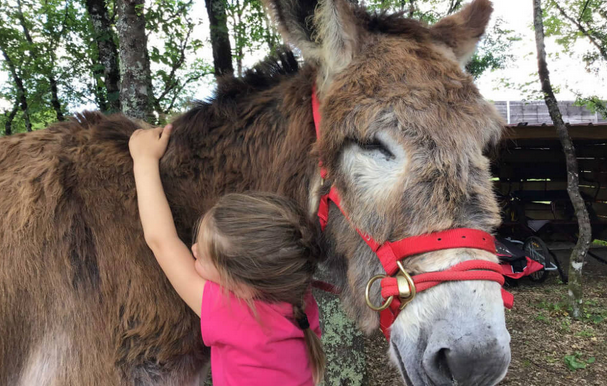

In [7]:
# Isolate the last convolutional layer
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
img_path = "./images/petite_fille_ane.png"

# Visualize the image
display(Image(img_path))

## The Grad-CAM algorithm

In [9]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3). We do this because this dimension is needed for most built-in functions
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    # The variable "prediction_rank" is used to apply gradcam on the top class
    # You can modify it to prediction_rank=n for a heatmap on the nth top class

    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # GradientTape() is a built-in Tensorflow tool to record operations for automatic differentiation.
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # We compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        # We pass the activations of the last conv in our classifier_model to obtain the predictions of the model
        preds = classifier_model(last_conv_layer_output)
        # This prediction has a shape=(1, 1000) because there is 1000 classes in ImageNet.
        # We find the index of the top prediction and we call it pred_index, because it's the index of the prediction
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        # We only keep the value of the prediction at the position of the pred_index
        top_class_channel = preds[:, pred_index]


    # This is the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation for the top class
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's use it

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top 1 Prediction: [('n02437616', 'llama', 0.6058315)]
Top 3 Predictions: [('n02437616', 'llama', 0.6058315), ('n02437312', 'Arabian_camel', 0.05544158), ('n01877812', 'wallaby', 0.01443628)]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


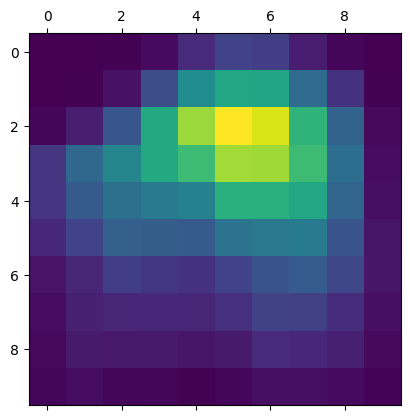

In [10]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is (Angora stands for Angora Rabbit in ImageNet labels)
# According to https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/decode_predictions
# decode_predictions() returns a list of lists of top class prediction tuples (class_name, class_description, score)
# class_name is the internal name of the class, class_description the name in natural language and score is the probability of this prediction.
# top=1 is used to have the top class and [0] to have the first element of the list.
preds = model.predict(img_array)
print("Top 1 Prediction:", decode_predictions(preds, top=1)[0])

# In order to check the 2nd and 3rd predicted class, we also print the predictions with top=3
print("Top 3 Predictions:", decode_predictions(preds, top=3)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap. This heatmap is normalized for visualisation purpose, as explained in make_gradcam_heatmap()
# Thanks to that, we can know what part of the image was the most important to predict the top class
plt.matshow(heatmap)
plt.show()

In [12]:
# Effectuer la prédiction sur l'image prétraitée
preds = model.predict(img_array)

# Décoder la prédiction pour obtenir le nom de la classe
# decode_predictions renvoie une liste de listes de tuples (class_id, class_name, score)
top_pred = decode_predictions(preds, top=1)[0][0]
class_id, class_name, score = top_pred

# Afficher le nom de la classe prédite ainsi que son score
print("Classe prédite :", class_name)
print("Score :", score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Classe prédite : llama
Score : 0.6058315


## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it

<ipython-input-11-5ca61a271316>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


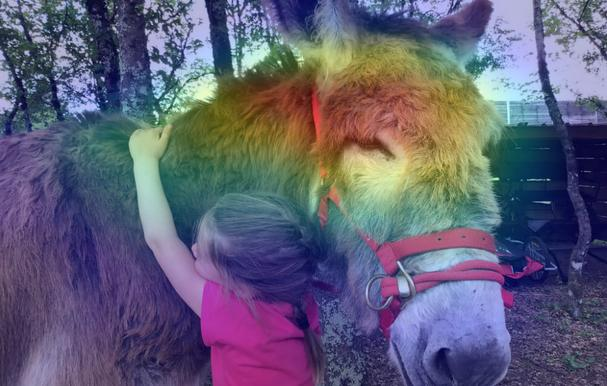

In [11]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255 (because earlier, for visualization purpose, we normalized the heatmap between 0 & 1)
# We rescale it on this range to have it in RGB, so that we can superimpose it on the rabbit picture.
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "rabbit_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

## Perfect!

Now we know that the model "looked" at the center of the image, where the head of the rabbit is located, in order to make its prediction.

We can be glad we have a rabbit detector and not a carrot or a kitchen detector!

You can now have fun by testing this method on other images!